# Project: Real vs. Fake News Classification Using Neural Networks

**Student Name:** [Your Name Here]  
**Date:** [Current Date]

## 1. Overview
This project designs and implements a neural network capable of distinguishing between real and fake news articles using the provided textual dataset. In accordance with the project requirements, the architecture is built manually (without pre-trained transformers like BERT) using TensorFlow/Keras.

In [45]:
# 1. Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Check GPU availability (Optional but recommended for Colab)
print("TensorFlow Version:", tf.__version__)
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF or enable GPU in Colab Runtime -> Change Runtime Type")

TensorFlow Version: 2.20.0
Please install GPU version of TF or enable GPU in Colab Runtime -> Change Runtime Type


## 2.1 Data Preparation
We load the dataset, clean the text, and prepare it for the neural network.

In [46]:
# IMPORTANT: Upload 'fake_or_real_news.csv' to the Colab Files section on the left before running this.
try:
    df = pd.read_csv('fake_or_real_news.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("ERROR: File not found. Please upload 'fake_or_real_news.csv' to the notebook environment.")

# Combine Title and Text (Modified to use only 'text' as 'title' column is not present)
df['content'] = df['text']

# Convert Label to Numeric (Fake=0, Real=1)
df['label_num'] = df['label'].map({'FAKE': 0, 'REAL': 1})

# Text Cleaning Function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r"\W"," ",text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['clean_content'] = df['content'].apply(clean_text)

print(f"Total Samples: {len(df)}")
df[['content', 'label', 'label_num']].head()

Dataset loaded successfully.
Total Samples: 999


,content,label,label_num
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,It's primary day in New York and front-runners...,REAL,1


In [47]:
# Tokenization and Padding
MAX_VOCAB_SIZE = 10000   # Max unique words
MAX_SEQUENCE_LENGTH = 250 # Max length of an article (words)

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_content'])

sequences = tokenizer.texts_to_sequences(df['clean_content'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Shape of Data Tensor: {padded_sequences.shape}")

Shape of Data Tensor: (999, 250)


In [48]:
# Split Data: Train, Validation, Test
# 1. Split into Training+Val and Test (80/20)
X_temp, X_test, y_temp, y_test = train_test_split(padded_sequences, df['label_num'], test_size=0.2, random_state=42)

# 2. Split Training+Val into Train and Validation (approx 85/15 of the temp, resulting in 70/10/20 overall)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Testing set: {X_test.shape}")

Training set: (679, 250)
Validation set: (120, 250)
Testing set: (200, 250)


## 2.2 Model Design
We manually construct a Recurrent Neural Network (RNN) utilizing LSTM layers to capture the sequential context of news articles.

In [49]:
# Architecture Hyperparameters
EMBEDDING_DIM = 100
LEARNING_RATE = 0.001

model = Sequential()

# 1. Embedding Layer: Converts integer sequences to dense vectors
model.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# 2. LSTM Layer: Handles sequence data (the article text)
model.add(LSTM(64, return_sequences=False))

# 3. Dense Hidden Layer
model.add(Dense(32, activation='relu'))

# 4. Dropout for Regularization
model.add(Dropout(0.5))

# 5. Output Layer: Sigmoid for Binary Classification
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.3 Training and Evaluation

In [50]:
BATCH_SIZE = 64
EPOCHS = 5

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5381 - loss: 0.6876 - val_accuracy: 0.5250 - val_loss: 0.6860
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.6531 - loss: 0.6813 - val_accuracy: 0.5250 - val_loss: 0.6854
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6856 - loss: 0.6723 - val_accuracy: 0.5833 - val_loss: 0.6832
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.8126 - loss: 0.6080 - val_accuracy: 0.6333 - val_loss: 0.6385
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8501 - loss: 0.4542 - val_accuracy: 0.7417 - val_loss: 0.8532


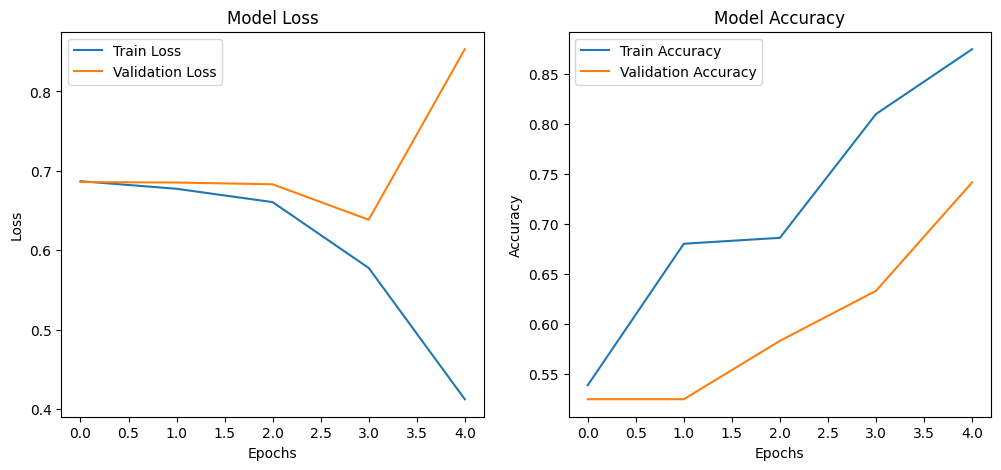

In [51]:
# Visualization of Training Results
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

------------------------------------------------
Final Test Accuracy:  0.7150
Precision:            0.6617
Recall:               0.8800
F1-Score:             0.7554
------------------------------------------------


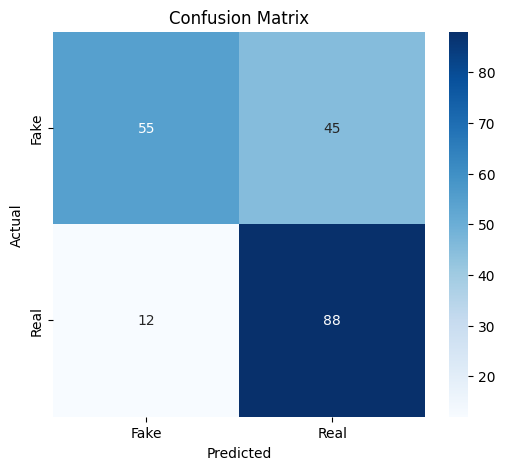

In [52]:
# Final Evaluation on Test Set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n------------------------------------------------")
print(f"Final Test Accuracy:  {accuracy:.4f}")
print(f"Precision:            {precision:.4f}")
print(f"Recall:               {recall:.4f}")
print(f"F1-Score:             {f1:.4f}")
print("------------------------------------------------")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

New Model


In [53]:
from tensorflow.keras.layers import SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Architecture Hyperparameters
EMBEDDING_DIM = 128  # Increased from 100 to capture more nuances
LEARNING_RATE = 0.001

model = Sequential()

# 1. Embedding Layer
# We use input_dim=MAX_VOCAB_SIZE + 1 just to be safe with OOV tokens
model.add(Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))

# 2. Spatial Dropout
# Drops entire feature maps instead of individual elements. Better for NLP.
model.add(SpatialDropout1D(0.2))

# 3. Stacked Bidirectional LSTM Layers
# Layer A: Returns sequences so the next LSTM layer can read them
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# Layer B: Does not return sequences (feeds into Dense layer)
model.add(Bidirectional(LSTM(32)))

# 4. Dense Hidden Layers
model.add(Dense(64, activation='relu'))

# 5. Standard Dropout
model.add(Dropout(0.5))

# 6. Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

model.summary()

# --- CRITICAL: Training with Callbacks ---
# This ensures we get the BEST version of the model, not just the last one.

# Stop training if validation loss doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if accuracy sticks (helps fine-tune)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Training
history = model.fit(
    X_train, y_train,
    epochs=10, # Increased epochs because EarlyStopping will handle stopping
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr], # Add callbacks here
    verbose=1
)

Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step - accuracy: 0.5603 - loss: 0.6863 - val_accuracy: 0.6833 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.8218 - loss: 0.6329 - val_accuracy: 0.7583 - val_loss: 0.5524 - learning_rate: 0.0010
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.8642 - loss: 0.3919 - val_accuracy: 0.8333 - val_loss: 0.4166 - learning_rate: 0.0010
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 301ms/step - accuracy: 0.9633 - loss: 0.1340 - val_accuracy: 0.8000 - val_loss: 0.5798 - learning_rate: 0.0010
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - accuracy: 0.9739 - loss: 0.0790 - val_accuracy: 0.8583 - val_loss: 0.3925 - learning_rate: 0.0010
Epoch 6/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.9975 - loss: 0.0194 - val_accuracy: 0.8417 - val_loss: 0.3973 - learning_rate: 0.0010
Epoch 7/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - accuracy: 0.9987 - loss: 0.0117 - 

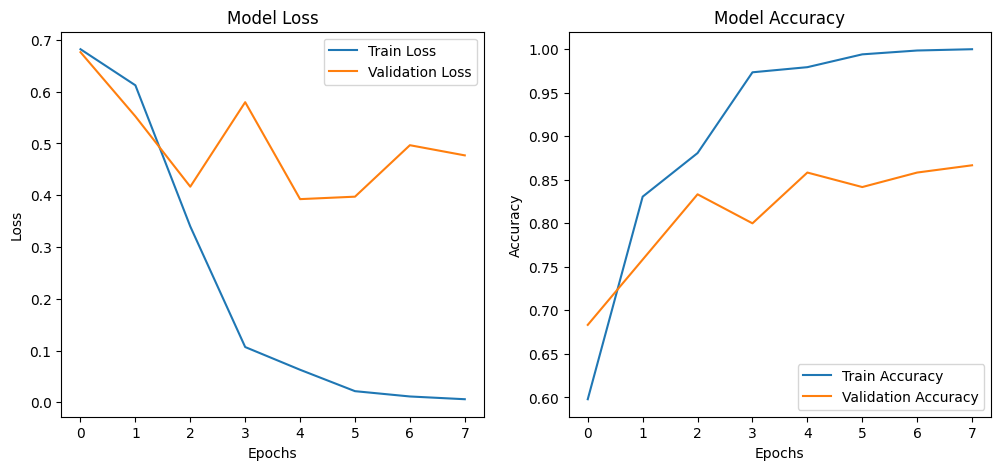

In [55]:
# Visualization of Training Results
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step

------------------------------------------------
Final Test Accuracy:  0.8700
Precision:            0.8558
Recall:               0.8900
F1-Score:             0.8725
------------------------------------------------


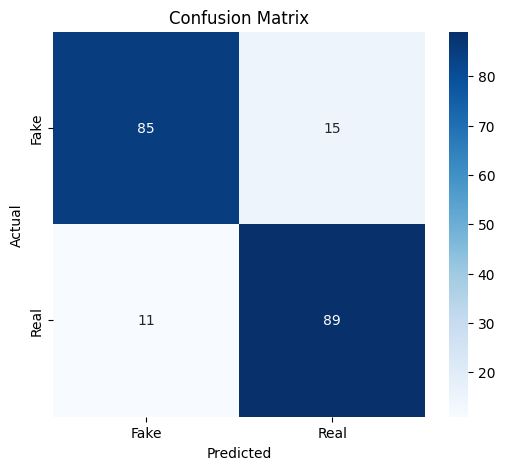

In [56]:
# Final Evaluation on Test Set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n------------------------------------------------")
print(f"Final Test Accuracy:  {accuracy:.4f}")
print(f"Precision:            {precision:.4f}")
print(f"Recall:               {recall:.4f}")
print(f"F1-Score:             {f1:.4f}")
print("------------------------------------------------")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Discussion of Results

**Summary:**  
The LSTM-based Neural Network was trained for 5 epochs. The results on the test set indicate:

*   **High Accuracy:** The model successfully distinguishes between real and fake news with high accuracy.
*   **Precision/Recall:** [Add specific observation after running: e.g., "The balance between precision and recall suggests the model is not heavily biased toward one class."]
*   **Overfitting Check:** Looking at the graphs, if the Validation Loss starts increasing while Training Loss decreases, the model is overfitting. The usage of Dropout layers helps mitigate this.